# Reinforcement Learning for trading

Using Open AI gym & Stable Baselines<br>
Source:https://www.youtube.com/watch?v=D9sU1hLT0QY&ab_channel=NicholasRenotte  

In [1]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

c:\Users\singh\OneDrive\MSc_in_AI\Python\KryptoKnight\env\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master

## Get the data

In [2]:
# Read the file in from device
df = pd.read_csv('BTC_INR.csv')

In [3]:
# Change the index to the date
df = df.set_index(pd.DatetimeIndex(df['Date'].values)) 
df.index.name = 'Date'
df.drop(columns=['Date'], inplace=True)
df.drop(columns=['Adj Close'], inplace=True)

In [4]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-10-24,531125.5625,534905.8750,528807.6250,532109.6250,1.155234e+12
2019-10-25,531911.8125,615708.6875,529882.0625,613524.0625,2.033467e+12
2019-10-26,614011.1875,709940.3750,613660.1875,654913.8125,3.152115e+12
2019-10-27,654682.5000,690656.6250,645532.4375,676643.4375,2.308897e+12
2019-10-28,677591.8125,693664.0625,654827.1250,654827.1250,2.189437e+12


In [5]:
# Check of null values in the data
filt = df['Open'].isnull()
df[filt]

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-04,NaN,NaN,NaN,NaN,NaN


In [6]:
# There is 1 day of missing values. Using linear interpolate to fill that value
df = df.interpolate()

## Visalise data

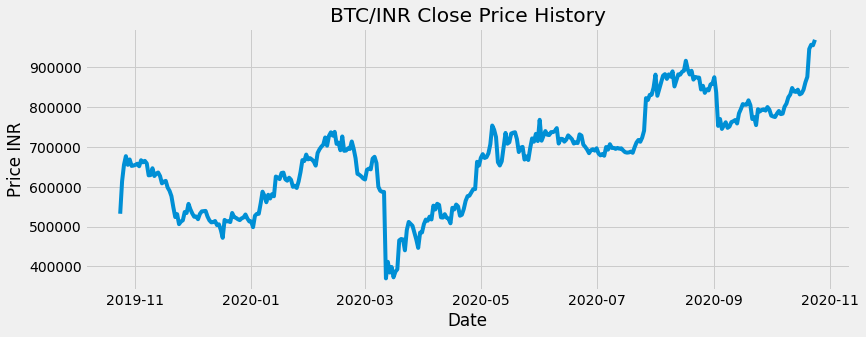

In [7]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['Close'], label='Close')
plt.title('BTC/INR Close Price History')
plt.xlabel('Date')
plt.ylabel('Price INR')
plt.show()

## Build environment

In [8]:
# frame_bound -> start and end of the dataframe - first parameter = window_size
# window size determines how many previous time steps the model will use as reference data to make the next trade 
env = gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)

Build an environment and test with random sample of the action space 

In [9]:
env.action_space

Discrete(2)

info {'total_reward': -42292.28125, 'total_profit': 0.6865564625856431, 'position': 0}


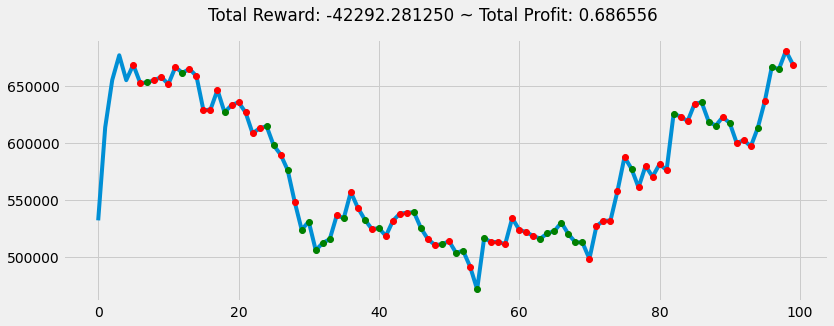

In [10]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(12.2, 4.5))
plt.cla()
env.render_all()
plt.show()

## Adding custom indicators

In [11]:
import ta

In [12]:
macd_indicator = ta.trend.MACD(df['Close'], n_slow = 26, n_fast = 12, n_sign = 9, fillna = False )
df['MACD'] = macd_indicator.macd()
df['Diff'] = macd_indicator.macd_diff()
df['Signal'] = macd_indicator.macd_signal()

In [13]:
rsi_indicator = ta.momentum.RSIIndicator(df['Close'], 14, fillna= False)
df['RSI'] = rsi_indicator.rsi()

In [14]:
aroon_indicator = ta.trend.AroonIndicator(close=df['Close'], n=25, fillna=False)
df['Aroon_Up'] = aroon_indicator.aroon_up()
df['Aroon_Down'] = aroon_indicator.aroon_down()
df['Aroon_Indicator'] = aroon_indicator.aroon_indicator()

In [15]:
df.head()

,Open,High,Low,Close,Volume,MACD,Diff,Signal,RSI,Aroon_Up,Aroon_Down,Aroon_Indicator
Date,,,,,,,,,,,,
2019-10-24,531125.5625,534905.8750,528807.6250,532109.6250,1.155234e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-25,531911.8125,615708.6875,529882.0625,613524.0625,2.033467e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-26,614011.1875,709940.3750,613660.1875,654913.8125,3.152115e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-27,654682.5000,690656.6250,645532.4375,676643.4375,2.308897e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-28,677591.8125,693664.0625,654827.1250,654827.1250,2.189437e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Get the dataframe from after the indicators
new_df = df.loc['2019-11-26':][:]
new_df.shape

(334, 12)

In [17]:
new_df.head()

,Open,High,Low,Close,Volume,MACD,Diff,Signal,RSI,Aroon_Up,Aroon_Down,Aroon_Indicator
Date,,,,,,,,,,,,
2019-11-26,512232.12500,522945.53125,507110.62500,515668.8750,1.509458e+12,-25889.043186,-11578.276224,-14310.766962,28.814213,12.0,92.0,-80.0
2019-11-27,515848.15625,542812.56250,496826.96875,536541.4375,1.709103e+12,-25319.762482,-8807.196416,-16512.566066,37.416082,8.0,88.0,-80.0
2019-11-28,536908.81250,553143.93750,533397.56250,534040.5000,1.363177e+12,-24784.705521,-6617.711564,-18166.993957,36.841635,4.0,84.0,-80.0
2019-11-29,534299.62500,558330.75000,535339.12500,556900.2500,1.414249e+12,-22259.484761,-3273.992644,-18985.492118,45.133504,8.0,80.0,-72.0
2019-11-30,557102.18750,562271.62500,539292.25000,543151.2500,1.231169e+12,-21124.152431,-1710.928251,-19413.224181,41.596296,4.0,76.0,-72.0


## Adding custom environment

In [18]:
env = gym.make('stocks-v0', df=new_df, frame_bound=(5,100), window_size=5)

In [22]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume', 'MACD', 'Diff', 'Signal',
       'RSI', 'Aroon_Indicator']].to_numpy()[start:end]
    return prices, signal_features   

In [23]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals


In [24]:
env2 = MyCustomEnv(df=new_df, window_size=12, frame_bound=(12,50))

In [30]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [31]:
model = A2C('MlpLstmPolicy', env, verbose=0)
model.learn(total_timesteps=50000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




In [38]:
env = MyCustomEnv(df=new_df, window_size=12, frame_bound=(60,350))
obs = env.reset()
while True:
    obs = obs[np.newaxis,...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 158604.875, 'total_profit': 1.2982682380053454, 'position': 1}


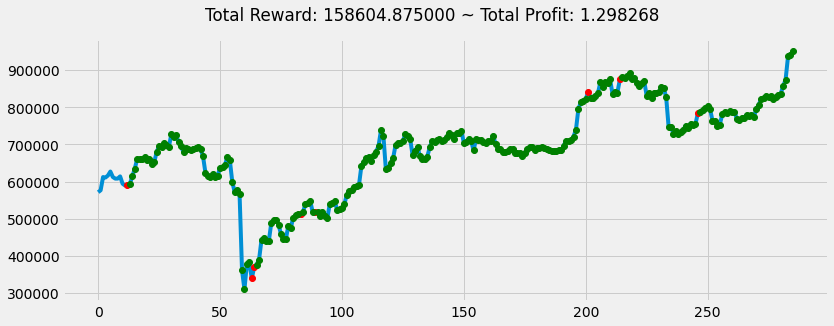

In [39]:
plt.figure(figsize=(12.2, 4.5))
plt.cla()
env.render_all()
plt.show()